In [53]:
import pandas as pd
# Import libraries necessary for this project
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import DefaultTagger
import datetime as dt

In [54]:
df = pd.read_csv("../data/customer_segmentation.csv", encoding= 'unicode_escape')

In [55]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [56]:
df.size

4335272

In [57]:
df.shape

(541909, 8)

In [58]:
df_1 = df.drop('CustomerID', axis=1)
display(df_1.describe())

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Checking for null values

In [59]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

25% of entries are not assigned to a particular customer.
 it is impossible to impute values for the user and these entries

In [60]:
#dropping na values.
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [61]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [62]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [63]:
df.shape

(406829, 8)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [65]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('number of countries: {}'.format(len(countries)))

number of countries: 37


In [66]:
df.Country.value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [67]:
#the number of products purchased in every transaction
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')


,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


some values of the StockCode variable indicate a particular transaction (i.e. POST for POSTAGED). 
checking the contents by looking for the set of codes that would contain only letters.

In [68]:
#stock code column contents
df_cleaned = df.copy(deep = True)
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [69]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


In [70]:
# creating a column contains total price of every purchase
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'])
df_cleaned.sort_values('CustomerID')[:5]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom,-77183.6
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,8/2/2011 8:48,2.25,12347.0,Iceland,13.5
72263,542237,47559B,TEA TIME OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland,12.5
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland,12.5


In [71]:
df_cleaned.sample(5, random_state=33)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
185362,552811,23284,DOORMAT KEEP CALM AND COME IN,10,5/11/2011 12:43,6.75,17677.0,United Kingdom,67.50
457072,575730,22144,CHRISTMAS CRAFT LITTLE FRIENDS,1,11/10/2011 19:53,2.10,14765.0,United Kingdom,2.10
81527,543162,22930,BAKING MOULD HEART MILK CHOCOLATE,2,2/3/2011 18:08,2.55,17507.0,United Kingdom,5.10
424470,C573268,M,Manual,-1,10/28/2011 12:50,907.00,12748.0,United Kingdom,-907.00
401556,571441,22420,LIPSTICK PEN BABY PINK,5,10/17/2011 13:31,0.83,14096.0,United Kingdom,4.15


A. Making clusters of products


extracting useful information from the Description variable 

In [72]:
#checking the count of the dependent variable
df_cleaned["Description"].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
                                      ... 
ANTIQUE RASPBERRY FLOWER EARRINGS        1
WALL ART,ONLY ONE PERSON                 1
GOLD/AMBER DROP EARRINGS W LEAF          1
INCENSE BAZAAR PEACH                     1
PINK BAROQUE FLOCK CANDLE HOLDER         1
Name: Description, Length: 3896, dtype: int64

In [73]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


analyzing the content of the Description column.

1.extracting the names that appears in the  product description.


2.extracting the root of the word and aggregate the set of names associated with this particular root.


3.counting the number of times each root appears in the data.





In [74]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, columns = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[columns]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywords_roots:   
                keywords_roots[root].add(t)
                count_keywords[root] += 1                
            else:
                keywords_roots[root] = {t}
                count_keywords[root] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(columns,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

First step of the analysis: recapture the list of products

In [75]:
df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})

In [76]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Number of keywords in variable 'Description': 1483


The following variables are retured by the previous function.
keywords: the list of extracted keywords


keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots


count_keywords: dictionary listing the number of times every word is used

Then in order to sort the keywords according to their occurrences,  the count_keywords dictionary is converted into a list.

In [77]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

By examining the list I had noticed that some name are useless or does not give information.

Hence, I decided to discard these words also, to consider only the words that appear more than 13 times.

In [78]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 193


In [79]:
list_products_2 = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_products_2))

C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


The X indicates the words contained in the description of the products using the one-hot-encoding principle.

In [80]:
X_1 = X.to_numpy()

Creating clusters of products.

grouping the products into different classes.
using Average silhouette method, it is a measure of how well each data point fits its corresponding cluster. This method evaluates the quality of clustering.

In [81]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X_1)
    clusters = kmeans.predict(X_1)
    silhouette_avg = silhouette_score(X_1, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.13522490598497075
For n_clusters = 4 The average silhouette_score is : 0.13091622672029465
For n_clusters = 5 The average silhouette_score is : 0.09525597808425022
For n_clusters = 6 The average silhouette_score is : 0.10019623906895468
For n_clusters = 7 The average silhouette_score is : 0.11745509792390425
For n_clusters = 8 The average silhouette_score is : 0.09359988322838723
For n_clusters = 9 The average silhouette_score is : 0.11115113286137522


Retraining the clustering model  


Visualizing the model's performance with the elbow method which finds the value of the optimal number of clusters using the total within-cluster sum of square values.

Text(0, 0.5, 'Inertia')

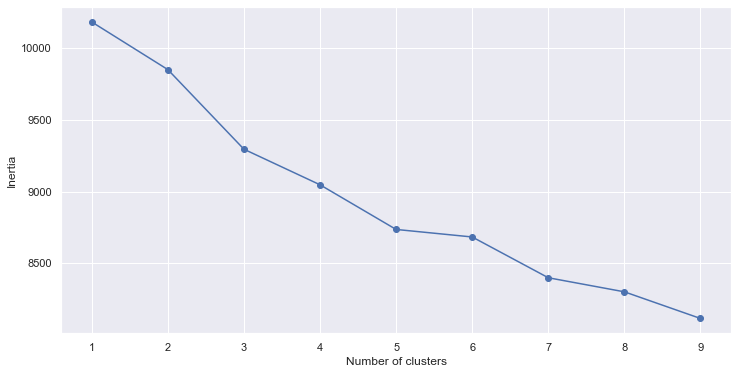

In [82]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(X_1)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Principal Component Analysis.

using a technique called Principal Component Analysis (PCA) to reduce the dimension of a dataset. 

When we run PCA on a data frame, new components are created.
 
These components explain the maximum variance in the model.

In [83]:
pca = PCA()
pca.fit(X_1)
pca_samples = pca.transform(X_1)

C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


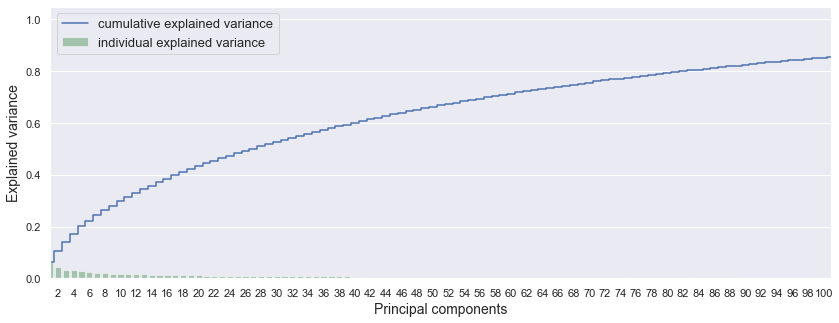

In [84]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X_1.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,X_1.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);


we need more than 100 components to explain 90% of the variance of the data

In [85]:
pca = PCA(n_components=50)
X_9D = pca.fit_transform(X_1)
X_2= pd.DataFrame(X_9D)
X_2['cluster'] = pd.Series(clusters)

In [86]:
kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(X_2)

# Now, print the silhouette score of this model

print(silhouette_score(X_2, kmeans.labels_, metric='euclidean'))

C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.4875232375751757


building the model after performing PCA 

C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised i

Text(0.5, 0, 'Number of clusters')

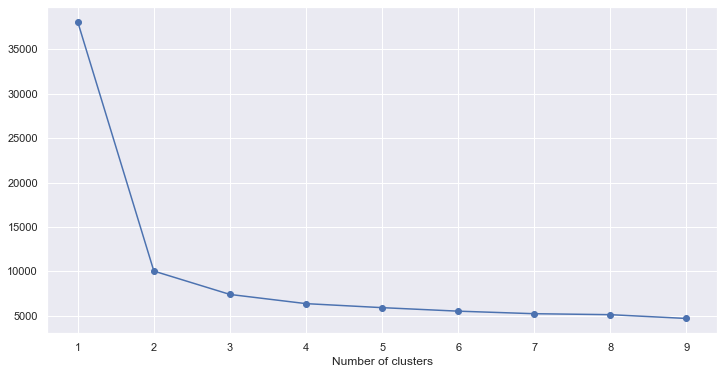

In [87]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(X_2)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')

([<matplotlib.axis.XTick at 0xbbcc2beaf0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

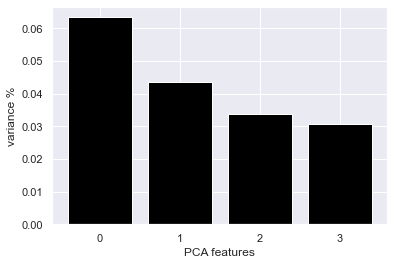

In [88]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X_1)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Re-Train K means model with first two principal components

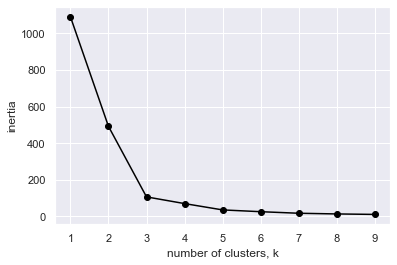

In [89]:
PCA_components = pd.DataFrame(principalComponents)
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

calculating the silhouette score for this model with 3 clusters

In [90]:
model = KMeans(n_clusters=3)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 

0.8913842405654673


In [91]:
#predict the labels of clusters.
label = kmeans.fit_predict(PCA_components)

print(label)


[6 1 2 ... 1 6 1]


Standardizing before creating clusters of customers.

In [92]:
scaler = StandardScaler()
scaler.fit(X_2)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_X= scaler.transform(X_2)

C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


variables mean values: 
------------------------------------------------------------------------------------------
 [-2.00615249e-17 -2.18852999e-17 -1.36783124e-17  0.00000000e+00
 -3.46517248e-17 -2.96363436e-17 -2.91803998e-17 -2.18852999e-17
  2.73566248e-17  9.11887495e-18  9.66600744e-17  2.05174686e-17
 -1.82377499e-18 -6.20083496e-17 -8.20698745e-18  2.42790045e-17
  3.82992748e-17 -1.82377499e-18 -3.19160623e-17 -3.54496264e-17
 -3.10041748e-17 -1.20825093e-16 -4.44545154e-18  1.82377499e-17
  6.83915621e-18  5.90447153e-17  6.61118434e-18 -4.46824872e-17
  6.38321246e-18 -2.47349483e-17 -3.10041748e-17  2.73566248e-17
  5.68219895e-17  3.80713029e-17 -1.82377499e-17  6.83915621e-18
  1.82377499e-18 -6.29202371e-17 -2.87244561e-17 -6.93034496e-17
 -1.29943968e-17 -5.15216434e-17 -2.27971874e-19  2.37660678e-17
 -1.73258624e-17  6.38321246e-18 -3.10041748e-17 -1.36783124e-17
  2.43929905e-17  9.11887495e-19  6.16529774e+00]


C:\Users\lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [93]:
pca = PCA()
pca.fit(scaled_X)
pca_samples = pca.transform(scaled_X)

Defining clusters of clients from the standardized x that was defined earlier and using the k-means algorithm.
11 clusters chosed based on the silhouette score.

In [94]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_X)
clusters_clients = kmeans.predict(scaled_X)
silhouette_avg = silhouette_score(scaled_X, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.126


 the number of customers in each cluster.

In [95]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,0,7,8,1,3,6,5,9,10,2,4
number of clients,2440,441,270,140,135,111,92,70,69,66,62


B. RFM segmentation


Using RFM to find the best customers.

RFM stands for Recency, Frequency and Monetary. 

In [99]:
data= df_cleaned[pd.notnull(df_cleaned['CustomerID'])]

<AxesSubplot:>

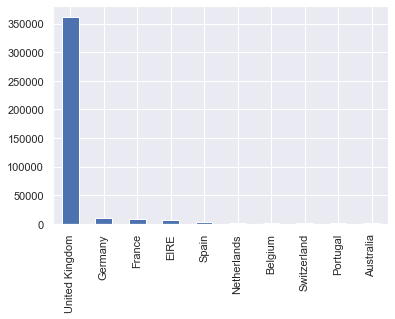

In [100]:
data.Country.value_counts()[:10].plot(kind='bar')

most of the customers are from the "United Kingdom".

filtering data for United Kingdom customer.

In [101]:
uk_df=data[data.Country=='United Kingdom']

In [102]:
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    361878 non-null  object 
 1   StockCode    361878 non-null  object 
 2   Description  361878 non-null  object 
 3   Quantity     361878 non-null  int64  
 4   InvoiceDate  361878 non-null  object 
 5   UnitPrice    361878 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      361878 non-null  object 
 8   TotalPrice   361878 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 27.6+ MB


In [103]:
uk_df_1 = uk_df.drop('CustomerID', axis=1)
uk_df_1.describe()

,Quantity,UnitPrice,TotalPrice
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,18.702086
std,263.129266,70.654731,451.918484
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,3.750000
50%,4.000000,1.950000,10.200000
75%,12.000000,3.750000,17.700000
max,80995.000000,38970.000000,168469.600000


some customers have ordered in a negative quantity, so we need to 

filter Quantity greater than zero

In [104]:
uk_df = uk_df[(uk_df['Quantity']>0)]
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    354345 non-null  object 
 1   StockCode    354345 non-null  object 
 2   Description  354345 non-null  object 
 3   Quantity     354345 non-null  int64  
 4   InvoiceDate  354345 non-null  object 
 5   UnitPrice    354345 non-null  float64
 6   CustomerID   354345 non-null  float64
 7   Country      354345 non-null  object 
 8   TotalPrice   354345 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 27.0+ MB


To perform the RFM analysis the first step is to filter the necessary columns.
 
we only need five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice.

CustomerID: define the customer.

InvoiceDate: help with calculating the recency of purchase.

InvoiceNo: counting the number of time transaction performed.

Quantity purchased in each transaction and UnitPrice of each unit purchased by the customer will help to calculate the total purchased number.

In [105]:
uk_df=uk_df[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice', 'TotalPrice']]

In [106]:
uk_df['InvoiceDate'].min(),uk_df['InvoiceDate'].max()

('1/10/2011 10:32', '9/9/2011 9:52')

In [107]:
PRESENT = dt.datetime(2011,12,10)
uk_df['InvoiceDate'] = pd.to_datetime(uk_df['InvoiceDate'])

In [108]:
uk_df.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


RFM Analysis.

performing the following opertaions:

Recency: Calculate the number of days between present date and date of last purchase each customer.

Frequency: Calculate the number of orders for each customer.

Monetary: Calculate sum of purchase price for each customer.

In [109]:
rfm= uk_df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [110]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [111]:
# Changing the name of columns
rfm.columns=['monetary','frequency','recency']
rfm['recency'] = rfm['recency'].astype(int)

In [112]:
rfm.head()

,monetary,frequency,recency
CustomerID,,,
12346.0,325,1,77183
12747.0,2,103,4196
12748.0,0,4596,33719
12749.0,3,199,4090
12820.0,3,59,942


Computing Quantile of RFM values.

Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [113]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [114]:
rfm.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183,4,4,1
12747.0,2,103,4196,4,1,4
12748.0,0,4596,33719,4,1,4
12749.0,3,199,4090,4,1,4
12820.0,3,59,942,3,2,4


RFM Result.

Combining all three quartiles(r_quartile,f_quartile,m_quartile) in a single column,
 this rank used to segment the customers well group.

In [115]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183,4,4,1,441
12747.0,2,103,4196,4,1,4,414
12748.0,0,4596,33719,4,1,4,414
12749.0,3,199,4090,4,1,4,414
12820.0,3,59,942,3,2,4,324


In [116]:
# Filtering out cusotmers
rfm[rfm['RFM_Score']=='121'].sort_values('monetary', ascending=False).head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
17968.0,373,85,277,1,2,1,121
17908.0,373,58,243,1,2,1,121
17967.0,371,48,123,1,2,1,121
17860.0,368,58,252,1,2,1,121
16893.0,366,45,145,1,2,1,121


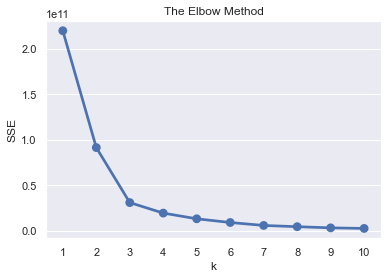

In [117]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [118]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(rfm)


KMeans(n_clusters=3, random_state=42)

summarizing the RFM table based on clusters and then calculating the mean of each variable.

In [119]:
rfm["Cluster"] = model.labels_
rfm.groupby('Cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(2)

recency frequency monetary      
              mean      mean     mean count
Cluster                                    
0          1357.39     83.07    92.26  3888
1         46875.37   1019.83    30.90    30
2        207559.67    257.00     2.67     3

cluster 0: is frequent and spend more also they buy the product recently.

cluster 1: is less frequent and less to spend, but they buy the product recently.

cluster 2 : is less frequent and less to spend, and they buy the product at old time.